## 1. Import packages

In [1]:
# Import packages
import hail as hl
from bokeh.io import output_notebook,show
import gnomad.utils.vep
from hail.ggplot import *
import plotly
import plotly.io as pio
pio.renderers.default='iframe'

In [2]:
%run -i ~/BroadIS/utils/01_maps_funcs.py

## 2. Import data

In [3]:
# Import gnomaAD v.3.1.2
ht = hl.read_table('gs://gcp-public-data--gnomad/release/3.1.2/ht/genomes/gnomad.genomes.v3.1.2.sites.ht')
ht = ht.head(100000) # Subset the data

# Import mutation rates from gnomAD paper
ht_mu = hl.import_table('data/supplementary_dataset_10_mutation_rates.tsv.gz',
                delimiter='\t', impute=True, force_bgz=True)
ht_mu = ht_mu.key_by('context', 'ref', 'alt') # has to have a key in order to join using foreign key

# Import context table from gnomad (https://broadinstitute.github.io/gnomad_methods/api_reference/utils/vep.html?highlight=context#gnomad.utils.vep.get_vep_context)
context_table = gnomad.utils.vep.get_vep_context("GRCh38").ht()
context_table_parsed = context_table.select(context_table.context)
context_table_parsed = context_table_parsed.transmute(context = context_table_parsed.context[2:5])

Initializing Hail with default parameters...


2022-09-29 23:32:20 WARN  NativeCodeLoader:60 - Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


2022-09-29 23:32:22 WARN  Utils:69 - Service 'SparkUI' could not bind on port 4040. Attempting port 4041.
2022-09-29 23:32:22 WARN  Utils:69 - Service 'SparkUI' could not bind on port 4041. Attempting port 4042.


Running on Apache Spark version 3.1.3
SparkUI available at http://192.168.0.181:4042
Welcome to
     __  __     <>__
    / /_/ /__  __/ /
   / __  / _ `/ / /
  /_/ /_/\_,_/_/_/   version 0.2.99-57537fea08d4
LOGGING: writing to /Users/adrian/BroadIS/01_maps/hail-20220929-2332-0.2.99-57537fea08d4.log
2022-09-29 23:32:35 Hail: INFO: Reading table to impute column types
2022-09-29 23:32:38 Hail: INFO: Finished type imputation
  Loading field 'context' as type str (imputed)
  Loading field 'ref' as type str (imputed)
  Loading field 'alt' as type str (imputed)
  Loading field 'methylation_level' as type int32 (imputed)
  Loading field 'mu_snp' as type float64 (imputed)


### Show the data structure

In [4]:
ht.show(3)

+---------------+------------+
| locus         | alleles    |
+---------------+------------+
| locus<GRCh38> | array<str> |
+---------------+------------+
| chr1:10031    | ["T","C"]  |
| chr1:10037    | ["T","C"]  |
| chr1:10043    | ["T","C"]  |
+---------------+------------+

+------------------------------------------------------------------------------+
| freq                                                                         |
+------------------------------------------------------------------------------+
| array<struct{AC: int32, AF: float64, AN: int32, homozygote_count: int32}>    |
+------------------------------------------------------------------------------+
| [(0,0.00e+00,56642,0),(2,1.65e-05,121094,0),(0,0.00e+00,25546,0),(0,0.00e... |
| [(2,2.60e-05,76882,0),(4,3.15e-05,126902,0),(0,0.00e+00,34670,0),(1,1.80e... |
| [(1,1.17e-05,85634,0),(1,8.24e-06,121430,0),(0,0.00e+00,39236,0),(0,0.00e... |
+------------------------------------------------------------------------------+

+------------------------------------------------------------------------------+
| raw_qual_hists.gq_hist_all.bin_edges                                         |
+------------------------------------------------------------------------------+
| array<float64>                                                               |
+------------------------------------------------------------------------------+
| [0.00e+00,5.00e+00,1.00e+01,1.50e+01,2.00e+01,2.50e+01,3.00e+01,3.50e+01,... |
| [0.00e+00,5.00e+00,1.00e+01,1.50e+01,2.00e+01,2.50e+01,3.00e+01,3.50e+01,... |
| [0.00e+00,5.00e+00,1.00e+01,1.50e+01,2.00e+01,2.50e+01,3.00e+01,3.50e+01,... |
+------------------------------------------------------------------------------+

+------------------------------------------------------------------------------+
| raw_qual_hists.gq_hist_all.bin_freq                                          |
+------------------------------------------------------------------------------+
| array<int64>                                                                 |
+------------------------------------------------------------------------------+
| [14149,7330,6840,3904,23217,2436,1647,594,176,118,49,29,19,9,11,6,5,2,4,2]   |
| [10121,5441,5610,3838,29394,3741,2868,1281,401,358,163,63,69,31,18,20,10,... |
| [6578,3782,4202,3336,31093,4532,3696,1752,595,585,261,88,82,59,17,26,14,5... |
+------------------------------------------------------------------------------+

+--------------------------------------+-------------------------------------+
| raw_qual_hists.gq_hist_all.n_smaller | raw_qual_hists.gq_hist_all.n_larger |
+--------------------------------------+-------------------------------------+
|                                int64 |                               int64 |
+--------------------------------------+-------------------------------------+
|                                    0 |                                   0 |
|                                    0 |                                   0 |
|                                    0 |                                   0 |
+--------------------------------------+-------------------------------------+

+------------------------------------------------------------------------------+
| raw_qual_hists.dp_hist_all.bin_edges                                         |
+------------------------------------------------------------------------------+
| array<float64>                                                               |
+------------------------------------------------------------------------------+
| [0.00e+00,5.00e+00,1.00e+01,1.50e+01,2.00e+01,2.50e+01,3.00e+01,3.50e+01,... |
| [0.00e+00,5.00e+00,1.00e+01,1.50e+01,2.00e+01,2.50e+01,3.00e+01,3.50e+01,... |
| [0.00e+00,5.00e+00,1.00e+01,1.50e+01,2.00e+01,2.50e+01,3.00e+01,3.50e+01,... |
+------------------------------------------------------------------------------+

+------------------------------------------------------------------------------+
| raw_q

In [5]:
# Table with methylation level and mutational rate in the trinucleotide context
ht_mu.show(3)

,,,,
context,ref,alt,methylation_level,mu_snp
str,str,str,int32,float64
"""AAA""","""A""","""C""",0,1.83e-09
"""AAA""","""A""","""G""",0,3.03e-09
"""AAA""","""A""","""T""",0,1.07e-09


In [6]:
# This table contains already precalculated nucleotides -3/+3 from mutation site 
context_table_parsed.show(3)

,,
locus,alleles,context
locus<GRCh38>,array<str>,str
chr1:10001,"[""T"",""A""]","""NTA"""
chr1:10001,"[""T"",""C""]","""NTA"""
chr1:10001,"[""T"",""G""]","""NTA"""


## 3. Add context field to main data

In [7]:
# Before joining the tri-nucleotide context of mutation
ht.count()

100000

In [8]:
# Join only matching rows from context to ht table.
#ht = ht.key_by('locus', 'alleles').join(context_table_parsed.key_by('locus', 'alleles'), how = 'left') # resorts the data making it slow
ht = ht.annotate(**context_table_parsed[ht.locus, ht.alleles])


In [9]:
# After
ht.count()

100000

## 4. Add mutation rates for added contexts

In [10]:
# Split alleles field to ref and alt allele
ht = ht.annotate(ref=ht.alleles[0], alt=ht.alleles[1])

# Add mutation rates according to the context, but also ref and alt allele for this context
#ht = ht.key_by("context", "ref", "alt").join(ht_mu.key_by("context", "ref", "alt"), how = 'left') # resorts the data making it slow
ht = ht.annotate(**ht_mu[ht.context, ht.ref, ht.alt])


In [11]:
# After adding context and mutation rates to the main table 
# (can be more than original number of rows as context may occure more than once depending on the locus)
ht.count()

100000

In [12]:
# Show that contexts may be the same, but locus is completely different
ht.show(3)

2022-09-29 23:33:39 Hail: INFO: Ordering unsorted dataset with network shuffle4]
2022-09-29 23:33:39 Hail: INFO: Coerced sorted dataset
2022-09-29 23:34:27 Hail: INFO: Ordering unsorted dataset with network shuffle4]


+---------------+------------+
| locus         | alleles    |
+---------------+------------+
| locus<GRCh38> | array<str> |
+---------------+------------+
| chr1:10031    | ["T","C"]  |
| chr1:10037    | ["T","C"]  |
| chr1:10043    | ["T","C"]  |
+---------------+------------+

+------------------------------------------------------------------------------+
| freq                                                                         |
+------------------------------------------------------------------------------+
| array<struct{AC: int32, AF: float64, AN: int32, homozygote_count: int32}>    |
+------------------------------------------------------------------------------+
| [(0,0.00e+00,56642,0),(2,1.65e-05,121094,0),(0,0.00e+00,25546,0),(0,0.00e... |
| [(2,2.60e-05,76882,0),(4,3.15e-05,126902,0),(0,0.00e+00,34670,0),(1,1.80e... |
| [(1,1.17e-05,85634,0),(1,8.24e-06,121430,0),(0,0.00e+00,39236,0),(0,0.00e... |
+------------------------------------------------------------------------------+

+------------------------------------------------------------------------------+
| raw_qual_hists.gq_hist_all.bin_edges                                         |
+------------------------------------------------------------------------------+
| array<float64>                                                               |
+------------------------------------------------------------------------------+
| [0.00e+00,5.00e+00,1.00e+01,1.50e+01,2.00e+01,2.50e+01,3.00e+01,3.50e+01,... |
| [0.00e+00,5.00e+00,1.00e+01,1.50e+01,2.00e+01,2.50e+01,3.00e+01,3.50e+01,... |
| [0.00e+00,5.00e+00,1.00e+01,1.50e+01,2.00e+01,2.50e+01,3.00e+01,3.50e+01,... |
+------------------------------------------------------------------------------+

+------------------------------------------------------------------------------+
| raw_qual_hists.gq_hist_all.bin_freq                                          |
+------------------------------------------------------------------------------+
| array<int64>                                                                 |
+------------------------------------------------------------------------------+
| [14149,7330,6840,3904,23217,2436,1647,594,176,118,49,29,19,9,11,6,5,2,4,2]   |
| [10121,5441,5610,3838,29394,3741,2868,1281,401,358,163,63,69,31,18,20,10,... |
| [6578,3782,4202,3336,31093,4532,3696,1752,595,585,261,88,82,59,17,26,14,5... |
+------------------------------------------------------------------------------+

+--------------------------------------+-------------------------------------+
| raw_qual_hists.gq_hist_all.n_smaller | raw_qual_hists.gq_hist_all.n_larger |
+--------------------------------------+-------------------------------------+
|                                int64 |                               int64 |
+--------------------------------------+-------------------------------------+
|                                    0 |                                   0 |
|                                    0 |                                   0 |
|                                    0 |                                   0 |
+--------------------------------------+-------------------------------------+

+------------------------------------------------------------------------------+
| raw_qual_hists.dp_hist_all.bin_edges                                         |
+------------------------------------------------------------------------------+
| array<float64>                                                               |
+------------------------------------------------------------------------------+
| [0.00e+00,5.00e+00,1.00e+01,1.50e+01,2.00e+01,2.50e+01,3.00e+01,3.50e+01,... |
| [0.00e+00,5.00e+00,1.00e+01,1.50e+01,2.00e+01,2.50e+01,3.00e+01,3.50e+01,... |
| [0.00e+00,5.00e+00,1.00e+01,1.50e+01,2.00e+01,2.50e+01,3.00e+01,3.50e+01,... |
+------------------------------------------------------------------------------+

+------------------------------------------------------------------------------+
| raw_q

## 4-5. Retrieve the gene for the most_severe_consequence

In [13]:
ht = gnomad.utils.vep.process_consequences(ht)

In [14]:
# worst_csq_for_variant - this field was added to the root ht.[vep]
ht.show()

2022-09-29 23:35:19 Hail: INFO: Ordering unsorted dataset with network shuffle4]
2022-09-29 23:35:19 Hail: INFO: Coerced sorted dataset
2022-09-29 23:36:02 Hail: INFO: Ordering unsorted dataset with network shuffle4]


+---------------+
| locus         |
+---------------+
| locus<GRCh38> |
+---------------+
| chr1:10031    |
| chr1:10037    |
| chr1:10043    |
| chr1:10055    |
| chr1:10057    |
| chr1:10061    |
| chr1:10061    |
| chr1:10064    |
| chr1:10067    |
| chr1:10108    |
+---------------+

+------------------------------------------------------------------------------+
| alleles                                                                      |
+------------------------------------------------------------------------------+
| array<str>                                                                   |
+------------------------------------------------------------------------------+
| ["T","C"]                                                                    |
| ["T","C"]                                                                    |
| ["T","C"]                                                                    |
| ["T","C"]                                                                    |
| ["A","C"]                                                                    |
| ["T","C"]                                                                    |
| ["T","TAACCCTAACCCTAACCCTAACCCTAACCCTAACCCTAACCCTAACCC"]                     |
| ["C","CCCTAACCCTAACCCTAACCCTAACCCTAACCCTAACCCTAACCCAACCCTAACCCTAACCCTAACC... |
| ["T","TAACCCTAACCCTAACCCTAACCCTAACCCTAACCCTAACCC"]                           |
| ["C","CA"]                                                                   |
+------------------------------------------------------------------------------+

+------------------------------------------------------------------------------+
| freq                                                                         |
+------------------------------------------------------------------------------+
| array<struct{AC: int32, AF: float64, AN: int32, homozygote_count: int32}>    |
+------------------------------------------------------------------------------+
| [(0,0.00e+00,56642,0),(2,1.65e-05,121094,0),(0,0.00e+00,25546,0),(0,0.00e... |
| [(2,2.60e-05,76882,0),(4,3.15e-05,126902,0),(0,0.00e+00,34670,0),(1,1.80e... |
| [(1,1.17e-05,85634,0),(1,8.24e-06,121430,0),(0,0.00e+00,39236,0),(0,0.00e... |
| [(1,1.06e-05,94152,0),(5,4.65e-05,107630,0),(0,0.00e+00,44378,0),(1,1.80e... |
| [(3,2.64e-05,113536,0),(3,2.41e-05,124252,0),(2,3.78e-05,52912,0),(0,0.00... |
| [(0,0.00e+00,108768,0),(2,1.70e-05,117852,0),(0,0.00e+00,50916,0),(0,0.00... |
| [(0,0.00e+00,108768,0),(7,5.94e-05,117852,0),(0,0.00e+00,50916,0),(0,0.00... |
| [(0,0.00e+00,149580,0),(1,6.62e-06,150996,0),(0,0.00e+00,67168,0),(0,0.00... |
| [(2,1.67e-05,119758,0),(10,7.87e-05,127024,1),(0,0.00e+00,55000,0),(2,2.7... |
| [(1,9.91e-05,10090,0),(1,7.19e-05,13906,0),(1,2.16e-04,4632,0),(0,0.00e+0... |
+------------------------------------------------------------------------------+

+------------------------------------------------------------------------------+
| raw_qual_hists.gq_hist_all.bin_edges                                         |
+------------------------------------------------------------------------------+
| array<float64>                                                               |
+------------------------------------------------------------------------------+
| [0.00e+00,5.00e+00,1.00e+01,1.50e+01,2.00e+01,2.50e+01,3.00e+01,3.50e+01,... |
| [0.00e+00,5.00e+00,1.00e+01,1.50e+01,2.00e+01,2.50e+01,3.00e+01,3.50e+01,... |
| [0.00e+00,5.00e+00,1.00e+01,1.50e+01,2.00e+01,2.50e+01,3.00e+01,3.50e+01,... |
| [0.00e+00,5.00e+00,1.00e+01,1.50e+01,2.00e+01,2.50e+01,3.00e+01,3.50e+01,... |
| [0.00e+00,5.00e+00,1.00e+01,1.50e+01,2.00e+01,2.50e+01,3.00e+01,3.50e+01,... |
| [0.00e+00,5.00e+00,1.00e+01,1.50e+01,2.00e+01,2.50e+01,3.00e+01,3.50e+01,... |
| [0.00e+00,5.00e+00,1.00e+01,1.50e+01,2.00e+01,2.50e+01,3.00e+01,3.50e+01,... |
| [0.00e+00,5.00e+00,1.00e+01,1.50e+01,2.00e+01,2.50e+01,3.00e+01,3.50e+01,... |
| [0.00e+00,5.00e+00,1.00e+01,1.50e+01,2.00e+01,2.50e+01,3.00e+0

## 5. Train linear model on synonymous variants for mutational class correction

In [15]:
ht_syn_ps = train_on_synonymous_per_gene_03b(ht)

2022-09-29 23:36:16 Hail: INFO: Table.join: renamed the following fields on the right to avoid name conflicts:
    'vep_csq_header' -> 'vep_csq_header_1'
    'filtering_model' -> 'filtering_model_1'
    'vep_version' -> 'vep_version_1'
    'freq_index_dict' -> 'freq_index_dict_1'
    'freq_meta' -> 'freq_meta_1'
    'faf_index_dict' -> 'faf_index_dict_1'
    'freq_sample_count' -> 'freq_sample_count_1'
    'age_distribution' -> 'age_distribution_1'
    'faf_meta' -> 'faf_meta_1'
    'dbsnp_version' -> 'dbsnp_version_1'


In [16]:
ht_syn_ps.show(3)

2022-09-29 23:37:01 Hail: INFO: Ordering unsorted dataset with network shuffle4]
2022-09-29 23:37:01 Hail: INFO: Coerced sorted dataset
2022-09-29 23:37:51 Hail: INFO: Coerced sorted dataset========>   (13 + 1) / 14]
2022-09-29 23:38:36 Hail: INFO: Ordering unsorted dataset with network shuffle4]
2022-09-29 23:38:36 Hail: INFO: Coerced sorted dataset
2022-09-29 23:39:23 Hail: INFO: Coerced sorted dataset             (8 + 6) / 14]


,,,,,,,
context,ref,alt,mu_snp,gene_id,N_variants,N_singletons,ps
str,str,str,float64,str,int64,int64,float64
"""AAT""","""A""","""G""",7.75e-09,"""ENSG00000186092""",1,1,1.00e+00
"""ACA""","""C""","""T""",9.32e-09,"""105378947""",1,NA,NA
"""ACA""","""C""","""T""",9.32e-09,"""ENSG00000186092""",1,NA,NA


### Show input table for regression

In [17]:
# How many rows after adding mutation rates
ht_syn_ps.count()

2022-09-29 23:40:14 Hail: INFO: Ordering unsorted dataset with network shuffle4]
2022-09-29 23:40:14 Hail: INFO: Coerced sorted dataset
2022-09-29 23:40:59 Hail: INFO: Coerced sorted dataset====>       (12 + 2) / 14]
2022-09-29 23:41:43 Hail: INFO: Ordering unsorted dataset with network shuffle4]
2022-09-29 23:41:43 Hail: INFO: Coerced sorted dataset
2022-09-29 23:42:31 Hail: INFO: Coerced sorted dataset             (9 + 5) / 14]


92

### Perform regression

In [18]:
# Perform regression
ht_syn_lm = ht_syn_ps.aggregate(hl.agg.linreg(ht_syn_ps.ps, [1, ht_syn_ps.mu_snp], weight=ht_syn_ps.N_variants).beta)

# Show intercept and beta
ht_syn_lm

2022-09-29 23:43:21 Hail: INFO: Ordering unsorted dataset with network shuffle4]
2022-09-29 23:43:22 Hail: INFO: Coerced sorted dataset
2022-09-29 23:44:07 Hail: INFO: Coerced sorted dataset             (8 + 6) / 14]
2022-09-29 23:44:47 Hail: INFO: Ordering unsorted dataset with network shuffle4]
2022-09-29 23:44:48 Hail: INFO: Coerced sorted dataset
2022-09-29 23:45:35 Hail: INFO: Coerced sorted dataset             (8 + 6) / 14]


[0.839813920347491, -8023788.936784587]

## 6. Predict expected number of variants for each context

### Function for regression eventually will be made starting here and put in `/utils/utils.py` script

In [19]:
maps_table = regress_per_context_per_gene_03b(ht, ht_syn_lm)

In [20]:
maps_table.show(maps_table.count())

2022-09-29 23:46:24 Hail: INFO: Ordering unsorted dataset with network shuffle4]
2022-09-29 23:46:24 Hail: INFO: Coerced sorted dataset
2022-09-29 23:47:11 Hail: INFO: Ordering unsorted dataset with network shuffle4]
2022-09-29 23:47:13 Hail: INFO: Ordering unsorted dataset with network shuffle4]
2022-09-29 23:47:58 Hail: INFO: Ordering unsorted dataset with network shuffle4]
2022-09-29 23:47:58 Hail: INFO: Coerced sorted dataset
2022-09-29 23:48:43 Hail: INFO: Ordering unsorted dataset with network shuffle4]
2022-09-29 23:49:26 Hail: INFO: Ordering unsorted dataset with network shuffle4]
2022-09-29 23:49:27 Hail: INFO: Coerced sorted dataset
2022-09-29 23:50:12 Hail: INFO: Ordering unsorted dataset with network shuffle4]
2022-09-29 23:50:17 Hail: INFO: Ordering unsorted dataset with network shuffle4]


,,,,,,,
consequence,gene_id,N_singletons,expected_singletons,N_variants,ps_agg,maps,maps_sem
str,str,int64,float64,int64,float64,float64,float64
"""3_prime_UTR_variant""","""105378947""",2,1.13e+01,36,5.56e-02,-2.58e-01,3.82e-02
"""3_prime_UTR_variant""","""112268260""",21,8.01e+01,241,8.71e-02,-2.45e-01,1.82e-02
"""3_prime_UTR_variant""","""ENSG00000186092""",67,1.53e+02,415,1.61e-01,-2.08e-01,1.81e-02
"""5_prime_UTR_variant""","""ENSG00000186092""",0,7.74e-01,5,0.00e+00,-1.55e-01,0.00e+00
"""downstream_gene_variant""","""100996442""",25,4.89e+01,304,8.22e-02,-7.85e-02,1.58e-02
"""downstream_gene_variant""","""ENSG00000186092""",410,9.32e+02,2515,1.63e-01,-2.08e-01,7.37e-03
"""downstream_gene_variant""","""ENSG00000238009""",297,5.71e+02,1489,1.99e-01,-1.84e-01,1.04e-02
"""frameshift_variant""","""105378947""",0,0.00e+00,9,0.00e+00,0.00e+00,0.00e+00


In [21]:
ggplot(maps_table, aes(x=maps_table.gene_id, y = maps_table.maps)) + geom_col(aes(fill=maps_table.consequence))


2022-09-29 23:51:02 Hail: INFO: Ordering unsorted dataset with network shuffle4]
2022-09-29 23:51:02 Hail: INFO: Coerced sorted dataset
2022-09-29 23:51:47 Hail: INFO: Ordering unsorted dataset with network shuffle4]
2022-09-29 23:52:28 Hail: INFO: Ordering unsorted dataset with network shuffle4]
2022-09-29 23:52:29 Hail: INFO: Coerced sorted dataset
2022-09-29 23:53:15 Hail: INFO: Ordering unsorted dataset with network shuffle4]
2022-09-29 23:53:20 Hail: INFO: Ordering unsorted dataset with network shuffle4]


In [22]:
ggplot(maps_table, aes(x=maps_table.gene_id, y = maps_table.maps)) + geom_col(aes(fill=maps_table.consequence), position='dodge')


2022-09-29 23:54:05 Hail: INFO: Ordering unsorted dataset with network shuffle4]
2022-09-29 23:54:05 Hail: INFO: Coerced sorted dataset
2022-09-29 23:54:49 Hail: INFO: Ordering unsorted dataset with network shuffle4]
2022-09-29 23:55:32 Hail: INFO: Ordering unsorted dataset with network shuffle4]
2022-09-29 23:55:32 Hail: INFO: Coerced sorted dataset
2022-09-29 23:56:20 Hail: INFO: Ordering unsorted dataset with network shuffle4]
2022-09-29 23:56:25 Hail: INFO: Ordering unsorted dataset with network shuffle4]


# Test plots

In [26]:
# from plotnine import * # facet needs it but also causes to break the whole script

ggplot(maps_table, aes(x=maps_table.gene_id, y = maps_table.maps)) + geom_col(aes(fill=maps_table.consequence))


2022-09-29 23:28:52 Hail: INFO: Ordering unsorted dataset with network shuffle4]
2022-09-29 23:28:53 Hail: INFO: Coerced sorted dataset
2022-09-29 23:29:40 Hail: INFO: Ordering unsorted dataset with network shuffle4]
2022-09-29 23:30:21 Hail: INFO: Ordering unsorted dataset with network shuffle4]
2022-09-29 23:30:22 Hail: INFO: Coerced sorted dataset
2022-09-29 23:31:07 Hail: INFO: Ordering unsorted dataset with network shuffle4]
2022-09-29 23:31:12 Hail: INFO: Ordering unsorted dataset with network shuffle4]


TypeError: cannot pickle '_thread.RLock' object

In [22]:


(
    ggplot(maps_table, aes(x=maps_table.gene_id, y = maps_table.maps)) 
    + geom_col(aes(fill=maps_table.gene_id))
    + facet_grid('consequence ~ .')
)

2022-09-29 23:09:48 Hail: INFO: Ordering unsorted dataset with network shuffle4]
2022-09-29 23:09:49 Hail: INFO: Coerced sorted dataset
2022-09-29 23:10:37 Hail: INFO: Ordering unsorted dataset with network shuffle4]
2022-09-29 23:11:20 Hail: INFO: Ordering unsorted dataset with network shuffle4]
2022-09-29 23:11:21 Hail: INFO: Coerced sorted dataset
2022-09-29 23:12:05 Hail: INFO: Ordering unsorted dataset with network shuffle4]
2022-09-29 23:12:10 Hail: INFO: Ordering unsorted dataset with network shuffle4]


TypeError: cannot pickle '_thread.RLock' object

In [23]:
(
    ggplot(maps_table, aes(x=maps_table.gene_id, y = maps_table.maps)) 
    + geom_col(aes(fill=maps_table.gene_id, position="dodge"))
    + facet_grid('consequence ~ .')
)

2022-09-29 23:16:21 Hail: INFO: Ordering unsorted dataset with network shuffle4]
2022-09-29 23:16:23 Hail: INFO: Coerced sorted dataset
2022-09-29 23:17:12 Hail: INFO: Ordering unsorted dataset with network shuffle4]
2022-09-29 23:17:55 Hail: INFO: Ordering unsorted dataset with network shuffle4]
2022-09-29 23:17:56 Hail: INFO: Coerced sorted dataset
2022-09-29 23:18:42 Hail: INFO: Ordering unsorted dataset with network shuffle4]
2022-09-29 23:18:47 Hail: INFO: Ordering unsorted dataset with network shuffle4]


TypeError: cannot pickle '_thread.RLock' object

2022-09-29 23:20:44 Hail: INFO: Ordering unsorted dataset with network shuffle4]
2022-09-29 23:20:45 Hail: INFO: Coerced sorted dataset
2022-09-29 23:21:36 Hail: INFO: Ordering unsorted dataset with network shuffle4]
2022-09-29 23:22:22 Hail: INFO: Ordering unsorted dataset with network shuffle4]
2022-09-29 23:22:22 Hail: INFO: Coerced sorted dataset
2022-09-29 23:23:09 Hail: INFO: Ordering unsorted dataset with network shuffle4]
2022-09-29 23:23:14 Hail: INFO: Ordering unsorted dataset with network shuffle4]
/Users/adrian/opt/anaconda3/envs/hail/lib/python3.10/site-packages/plotnine/layer.py:391: PlotnineWarning: position_stack : Removed 2 rows containing missing values.


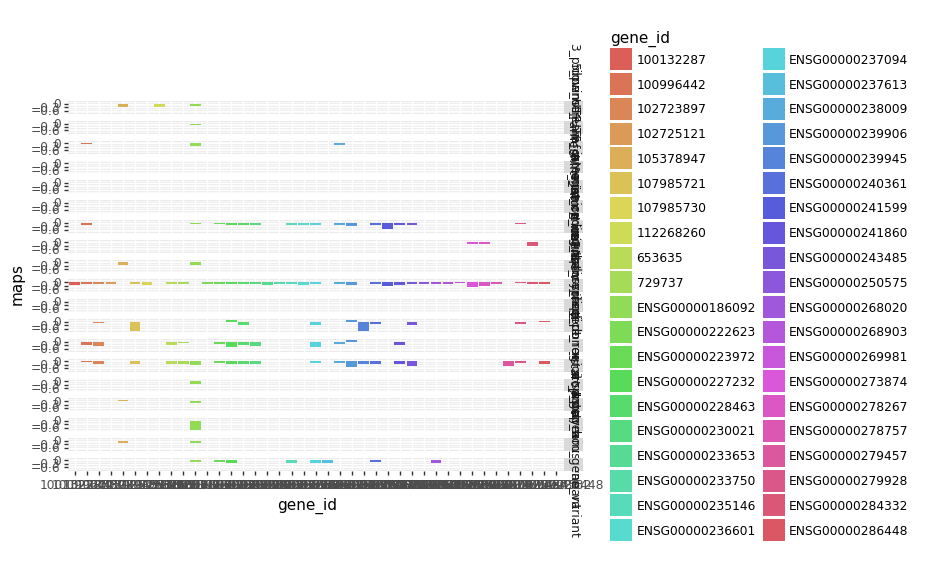

<ggplot: (8774493280914)>

In [24]:
ht_plot = maps_table.to_pandas()

(
    ggplot(ht_plot, aes(x=ht_plot.gene_id, y = ht_plot.maps)) 
    + geom_col(aes(fill=ht_plot.gene_id))
    + facet_grid('consequence ~ .')
)

In [37]:
ggplot(maps_table, aes(x=maps_table.gene_id, y = maps_table.maps)) + geom_col(aes(fill=maps_table.consequence))


ERROR (py4j.java_gateway 1126): An error occurred while trying to connect to the Java server (127.0.0.1:63190)
Traceback (most recent call last):
  File "/Users/adrian/opt/anaconda3/envs/hail/lib/python3.10/site-packages/py4j/java_gateway.py", line 977, in _get_connection
    connection = self.deque.pop()
IndexError: pop from an empty deque

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/Users/adrian/opt/anaconda3/envs/hail/lib/python3.10/site-packages/py4j/java_gateway.py", line 1115, in start
    self.socket.connect((self.address, self.port))
ConnectionRefusedError: [Errno 61] Connection refused


Py4JNetworkError: An error occurred while trying to connect to the Java server (127.0.0.1:63190)